In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import imp
imp.reload(cp)
print(cp.installed_solvers())

sns.set(style='darkgrid',font="DejaVu Serif",context="paper",palette='colorblind')

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


In [1]:
%store

Stored variables and their in-db values:
Aug10_CV_SSPOR_best_items                            -> '<unavailable>'
Aug10_CV_SSPOR_best_model                            -> SSPOR(basis=SVD(n_basis_modes=15), n_sensors=60,
 
Aug_2_2021_QDisagExpResults                          -> {'results_dicts': [{'res':      fun: 637.947790056
ERR_RESULTS_NO_VREF                                  -> {'pv_q_mse': [0.022004584053284135, 0.017650564687
X                                                    -> array([[ 1.06073459,  1.58319627,  1.11001599, ...
basis_expansion_3_param                              -> array([[ 2.28004282e+02,  2.32804372e+02, -2.23168
dailygran_qGMM_new_onlyOG                            -> '<unavailable>'
dailygran_summer_qGMM_new_onlyOG                     -> '<unavailable>'
df                                                   ->                      netloadP  netloadQ    netload
errors_Aug10_Cost_QR_SPPOR_GridCV                    -> [0.3343265784052703, 0.20508070565806452, 0.2

In [2]:
%store -r ieee13_mat_compl_ground_truth_08_23_2021
%store -r ieee123_mat_compl_perturb_08_31_2021

In [3]:
ieee13_mat_compl_ground_truth_08_23_2021.keys()

dict_keys(['S_IEEE13', 'S_IEEE13_df', 'injection_labels', 'voltages_basecase'])

# Item 0: Plot the Distributions of Sensitivity Coefficients for Each Network

In [4]:
S_13 = ieee13_mat_compl_ground_truth_08_23_2021['S_IEEE13']
S_13_df = ieee13_mat_compl_ground_truth_08_23_2021['S_IEEE13_df']
inj_labels_13 = ieee13_mat_compl_ground_truth_08_23_2021['injection_labels']


S_123 = ieee123_mat_compl_perturb_08_31_2021['S']
S_123_df = ieee123_mat_compl_perturb_08_31_2021['S_df']
inj_labels_123 = ieee123_mat_compl_perturb_08_31_2021['injection_labels']

## Make single column dataframes with labels corresponding to P/Q

In [5]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [6]:
#make dataframe
columns=['coef','label','inj_type']
S_coef_13_df = pd.DataFrame(columns=columns)

data = [] #collect row data at each iteration

for label in inj_labels_13:
    for coef in S_13_df[label]:
        values = [coef,label]
        if("P" in label):
            values.append('Active')
        if("Q" in label):
            values.append('Reactive')
        data.append(dict(zip(columns,values)))

S_coef_13_df = S_coef_13_df.append(data,True)

KL Divergence: 


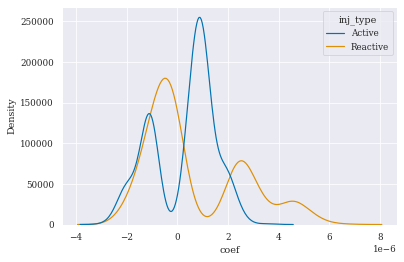

In [7]:
sns.kdeplot(data=S_coef_13_df,x='coef',hue='inj_type')
print("KL Divergence: ")

In [8]:
p = S_coef_13_df[S_coef_13_df['inj_type']=='Active']['coef'].values
q = S_coef_13_df[S_coef_13_df['inj_type']=='Reactive']['coef'].values
print(p.shape,q.shape)

(676,) (676,)


In [9]:
from scipy.stats import entropy
entropy(p,q)

inf

<AxesSubplot:xlabel='coef', ylabel='Density'>

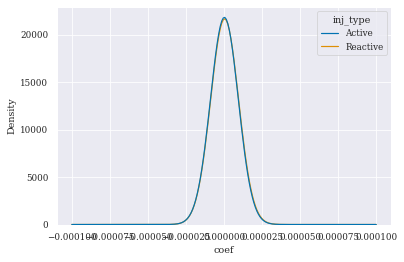

In [10]:
#make dataframe
columns=['coef','label','inj_type']
S_coef_123_df = pd.DataFrame(columns=columns)

data = [] #collect row data at each iteration

for label in inj_labels_123:
    for coef in S_123_df[label]:
        values = [coef,label]
        if("P" in label):
            values.append('Active')
        if("Q" in label):
            values.append('Reactive')
        data.append(dict(zip(columns,values)))

S_coef_123_df = S_coef_123_df.append(data,True)
sns.kdeplot(data=S_coef_123_df,x='coef',hue='inj_type',clip=(-0.0001,0.0001))

# Item 1. Sensitivity Matrix Completion

We observe a matrix $\mathbf{X}_0 \in \mathbb{R}^{M \times N}$ which we assume to have $\textbf{rank}(\mathbf{X}_0) = R << M,N$

Text(0.5, 1.0, 'IEEE 13 $\\tilde{\\mathbf{S}}$')

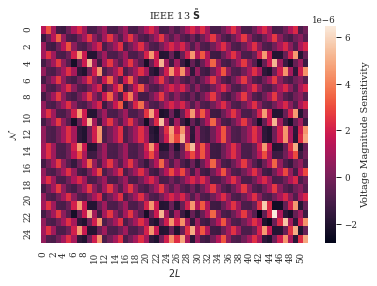

In [11]:
S_13 = ieee13_mat_compl_ground_truth_08_23_2021['S_IEEE13']
S_123 = ieee123_mat_compl_perturb_08_31_2021['S']
sns.heatmap(S_13,cbar_kws={'label':'Voltage Magnitude Sensitivity'})
plt.xlabel('$2L$')
plt.ylabel('$\mathcal{N}$')
plt.title(r"IEEE 13 $\tilde{\mathbf{S}}$")
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/sensitivity_mat.png")

## 1.1 Test this assumption:

Compute the truncated singular value decomposition representation using the Eckhart Young Theorem.

In [12]:
def spectral_analysis(S):
    """Computes normalized and commulative spectral analysis for a given matrix with the SVD"""
    u,sigma,vt = np.linalg.svd(S)
    sigma_total = np.sum(sigma)
    normed_sigma = sigma/sigma_total
    cum_sigma = np.cumsum(normed_sigma)
    return cum_sigma,normed_sigma

In [13]:
u,sigma,vt = np.linalg.svd(S_13)
print("Singular value vector: ",sigma.shape,sigma)

Singular value vector:  (26,) [4.41858831e-05 3.88814386e-05 1.84365903e-05 6.86546494e-06
 5.50587238e-06 2.85999983e-06 1.90708853e-06 1.85892687e-06
 1.49572390e-06 1.28127193e-06 1.18269446e-06 1.00567439e-06
 8.46469727e-07 8.15508511e-07 5.68108758e-07 4.43815107e-07
 4.08220612e-07 3.80413821e-07 3.56552725e-07 3.28873273e-07
 2.71675982e-07 2.51829259e-07 2.46379256e-07 2.04116926e-07
 1.70464206e-07 1.41225270e-07]


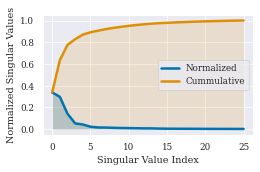

In [14]:
#Spectral analysis

sigma_total = np.sum(sigma)
normed_sigma = sigma/sigma_total
cum_sigma = np.cumsum(normed_sigma)

#Dataframe
spectral_df = pd.DataFrame()
spectral_df['Normalized Singular Values'] = normed_sigma
spectral_df['Cummulative Singular Values'] = cum_sigma
spectral_df['Singular Value Index'] = [i for i in range(0,26)]

fig,ax = plt.subplots(figsize=(3.5,3.5/1.61828),constrained_layout=True)
sns.lineplot(data=spectral_df,x='Singular Value Index',y='Normalized Singular Values',lw=2.5,rasterized=True)
sns.lineplot(data=spectral_df,x='Singular Value Index',y='Cummulative Singular Values',lw=2.5,rasterized=True)
plt.legend(["Normalized","Cummulative"])
plt.ylabel('Normalized Singular Values')

plt.fill_between(spectral_df['Singular Value Index'].values, spectral_df['Normalized Singular Values'].values,alpha=0.25)
plt.fill_between(spectral_df['Singular Value Index'].values, spectral_df['Cummulative Singular Values'].values,alpha=0.15)
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spectral_polished.pdf",dpi=380)

In [15]:
pwd()

'/home/sam/github/PowerSensitivities.jl/notebooks'

Text(0.5, 1.0, 'Spectral Analysis of IEEE 13 $\\tilde{\\mathbf{S}}$')

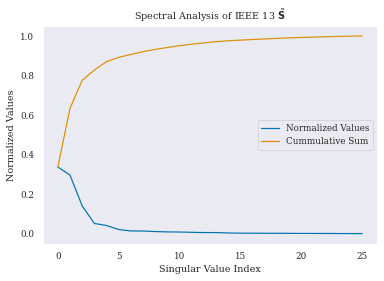

In [16]:

plt.plot(normed_sigma,label="Normalized Values")
plt.plot(cum_sigma,label="Cummulative Sum")
plt.legend()
plt.xlabel("Singular Value Index")
plt.grid()
plt.ylabel("Normalized Values")
plt.title(r"Spectral Analysis of IEEE 13 $\tilde{\mathbf{S}}$")
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spectral.png")

# Item 2: Low-Rank Matrix *Completion*
Matrix *completion* seeks to fill in an observed matrix $\mathbf{S}_0$ with unknown measurements:
$$
\min_{\mathbf{S} \in \mathbb{R}^{M \times 2L}} ||\mathbf{S} - \mathbf{S}_0||_F^2\\
\text{subject to: } \text{rank}(\mathbf{S})=R
$$

Where $||\mathbf{S} - \mathbf{S}_0||_F^2 = \sum_{m,n} (S[m,n]-S_0[m,n])^2$ is the squared Frobenius norm.

## 2.1: Linear Measurements and Spectral Analysis

In [17]:
def linear_measurements(S,pct_obs):
    """Generates an MxN matrix where pct_unobs are not seen"""
    m,n = S.shape
    # pick which entries we observe uniformly at random
    O = np.random.binomial(1,p=pct_obs,size=(m,n))
    return np.multiply(S,O)

Y = linear_measurements(S_13,pct_obs=0.60)

<AxesSubplot:>

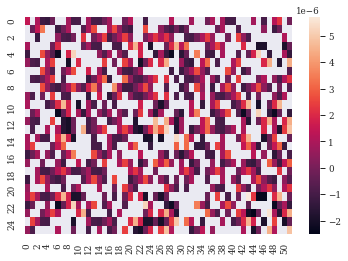

In [18]:
sns.heatmap(Y,mask=Y==0)

In [19]:
np.linalg.matrix_rank(Y)

26

In [20]:
m*n

NameError: name 'm' is not defined

In [21]:
x = np.arange(25).reshape(5, 5)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

<AxesSubplot:>

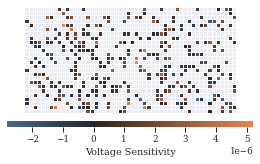

In [22]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
Y = linear_measurements(S_13,pct_obs=0.25)
sns.heatmap(Y,cmap=cmap,
            center=0,square=True,mask=Y==0,
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=0.9,
            #vmin=-0.05,vmax=0.05,
           cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
           rasterized=True)

#sns.heatmap(Y, mask=Y==0, cbar=False, ax=ax,
#            annot=False, annot_kws={"weight": "bold"})

#ax.set_title('Observed Entries in Sensitivity Matrix')
#plt.savefig("/home/sam/github/jacobian_discovery/Figures/matrix_incomplete_0_05pct.pdf",dpi=380)

In [23]:
np.linalg.matrix_rank(S_13)

26

## 2.2 Nuclear Norm Minimzation and Regularization Tuning

Instead of solving the standard matrix completion program derived from the Eckhart-Young Theorem:

$$
\min_{S} ||S - S_0||_F^2 \text{Subject to: rank}(S) = R
$$

we instead solve a *convex relaxtion* of the program:
$$
\min_{S} ||S - S_0||_F^2 + \lambda ||S||_*
$$

Where $$||S||_* = \sum_k \sigma_k(S)$$ is the *nuclear norm* - or sum of the singular values - and $\lambda$ is a hyperparameter.

In [23]:
def mat_com_loss(S,S0):
    return cp.sum_squares(S0 - S)

def mat_com_obj(S,S0,lamb):
    return mat_com_loss(S,S0) + mat_com_reg(S,lamb)
        
def mat_com_reg(S,lamb):
    return lamb*cp.atoms.norm(S,"nuc")

def mse(S_hat,S_0):
    m_,n_ = S_0.shape
    m,n = S_hat.shape
    assert m_ == m
    assert n_ == n
    return np.sqrt((1/m*n)*mat_com_loss(S_hat,S_0).value)


def frob_norm_err(S_hat,S):
    return ((cp.atoms.norm(S_hat-S,"fro"))/(cp.atoms.norm(S,"fro"))).value
    

In [24]:
A = np.array([[0,1,2,2,5,6,7],[2,3,3,4,5,6,7],[4,5,3,6,5,6,7]])
print(A)
print(A[:,1::2])

[[0 1 2 2 5 6 7]
 [2 3 3 4 5 6 7]
 [4 5 3 6 5 6 7]]
[[1 2 6]
 [3 4 6]
 [5 6 6]]


# Test Matrix Completion with Varying Levels of Observability

### Physics-based constraint

$$
(S^V_P)_{i,j} \neq (S^V_Q)_{i,j}
$$


In [25]:
S_13[:,0]

array([ 1.41825902e-06, -1.46479008e-06,  7.96622998e-07,  9.36084210e-07,
       -1.17128077e-06,  5.69066483e-07, -1.20677270e-06,  5.96352149e-07,
       -1.20620516e-06,  5.95828383e-07,  9.37423842e-07, -1.16421987e-06,
        5.65058922e-07,  5.65539326e-07,  9.25656653e-07,  9.58975016e-07,
       -1.19061950e-06,  5.87015619e-07,  9.69699419e-07, -1.20019586e-06,
        5.94752996e-07,  9.36084225e-07, -1.17128080e-06,  5.69066493e-07,
        9.31966039e-07,  5.65931501e-07])

In [57]:
def physics_constraints(y,S,eps=1e-9,M=100):
    dVdP = S[:,::2]
    dVdQ = S[:,1::2]
    #print(dVdQ)
    constraints = []
    for S_P_V_i,S_Q_V_i in zip(dVdP,dVdQ):
        
        for S_P_V_ij,S_Q_V_ij in zip(S_P_V_i,S_Q_V_i):
            #cons1 = S_P_V_ij - S_Q_V_ij <= -eps + M*y
            #cons2 = S_P_V_ij - S_Q_V_ij >= eps -(1-y)*M

            #constraints.append(cons1)
            #constraints.append(cons2)
            constraints.append(cp.abs(S_P_V_ij - S_Q_V_ij)>=0)
    return constraints
S = cp.Variable(S0.shape) #Decision variable
y = 1 #integer physics param
constraints = physics_constraints(y,S_13)

In [29]:
from tqdm import tqdm
#Range of possible percentages
percentages = np.linspace(0.1,0.9,50)

#Collect data per percentage
S_hat_optimal_by_pct = []
S_hats_by_pct = []
err_by_pct = []
cum_sigma_by_pct = []
normed_sigma_by_pct = []
chosen_lambds_by_pct = []


for pct in tqdm(percentages):
    S0 = linear_measurements(S_13,pct_obs=pct) #Observed incomplete matrix
    S = cp.Variable(S0.shape) #Decision variable
    #y = cp.Variable(boolean=True) #integer physics param
    lamb = cp.Parameter(nonneg=True) #Reg hyperparam
    #constraints = physics_constraints(y,S)
    prob = cp.Problem(cp.Minimize(mat_com_obj(S,S0,lamb))) #Problem
    lamb_values = np.logspace(-15,1,250) #Lambda values

    train_errors = []
    ground_truth_errors = []
    S_optimals = []
    for l in lamb_values:
        lamb.value = l
        prob.solve(verbose=False)
        train_errors.append(frob_norm_err(S,S0))
        test_err = frob_norm_err(S,S_13)
        ground_truth_errors.append(test_err)
        #print(test_err)
        S_optimals.append(S.value)

    #Get the optimal recovered S matrix
    opt_idx = np.argmin(ground_truth_errors)
    Shat = S_optimals[opt_idx]
    cum_sigma,normed_sigma = spectral_analysis(Shat)
    
    
    #Save the experiment data
    chosen_lambds_by_pct.append(lamb_values[opt_idx])
    S_hat_optimal_by_pct.append(Shat)
    S_hats_by_pct.append(S_optimals)
    cum_sigma_by_pct.append(cum_sigma)
    normed_sigma_by_pct.append(normed_sigma)
    err_by_pct.append(frob_norm_err(Shat,S_13))

100%|██████████| 50/50 [06:59<00:00,  8.39s/it]


In [54]:
#Truncate the SVD
from sklearn.decomposition import TruncatedSVD
r = 10
truncated = []
for S in S_hat_optimal_by_pct:
    svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
    truncated.append(svd.fit_transform(S)@svd.components_)



In [55]:
truncated_error = [frob_norm_err(s,S_13) for s in truncated]
print(np.linalg.matrix_rank(truncated[0]))

10


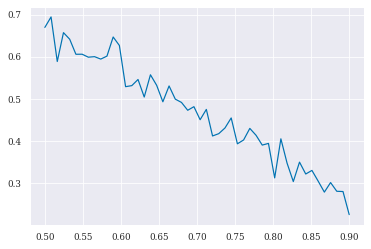

In [56]:
plt.plot(percentages,truncated_error)

In [30]:
#Collect S hats by lambda
chosen_idxs = np.array([25,50,200,215]) #Chosen lambda indeces
err_array = np.zeros((len(chosen_idxs),len(percentages)))
lambds_chosen = [lamb_values[i] for i in chosen_idxs]
for pct_idx,S_T in enumerate(S_hats_by_pct):
    for lambd_idx,s_t in enumerate(np.array(S_T)[chosen_idxs]):
        #lamb_array.append(lamb_values)
        err_array[lambd_idx,pct_idx] = frob_norm_err(s_t,S_13)
    

Text(0, 0.5, 'RMSE (V p.u.)')

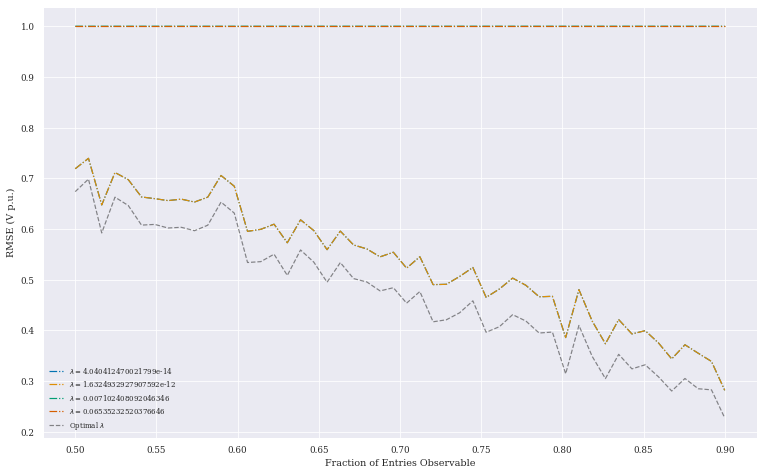

In [32]:
#err_df = pd.DataFrame
#err_df['']
fig,ax=plt.subplots(figsize=(3*3.5,3*3.5/1.61828),constrained_layout=True)
for lamb_idx,err_vec in enumerate(err_array):
    ax.plot(percentages,err_vec,'-.',label='$\lambda=$'+str(lambds_chosen[lamb_idx]),rasterized=True)

ax.plot(percentages,err_by_pct,'k--',label='Optimal $\lambda$',rasterized=True,alpha=0.5)
plt.legend(frameon=False,loc='lower left',fontsize=7)
#plt.xlim(0.01,0.825)
#plt.xlim()
#plt.xl
#plt.yscale('log')
plt.xlabel("Fraction of Entries Observable")
plt.ylabel("RMSE (V p.u.)")
#plt.savefig("/home/sam/github/jacobian_discovery/Figures/lambda_comparison_r1.pdf",dpi=390)

<AxesSubplot:>

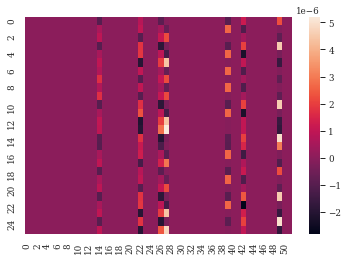

In [49]:
sns.heatmap(S_hats_by_pct[12][0])

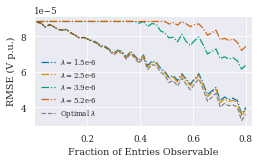

In [138]:
#err_df = pd.DataFrame
#err_df['']
fig,ax=plt.subplots(figsize=(3.5,3.5/1.61828),constrained_layout=True)
for lamb_idx,err_vec in enumerate(err_array):
    ax.plot(percentages,err_vec,'-.',label='$\lambda=$'+str(lambds_chosen[lamb_idx])[0:3]+"e-6",rasterized=True)

ax.plot(percentages,err_by_pct,'k--',label='Optimal $\lambda$',rasterized=True,alpha=0.5)
plt.legend(frameon=False,loc='lower left',fontsize=7)
plt.xlim(0.001,0.825)
#plt.xlim()
#plt.xl
#plt.yscale('log')
plt.xlabel("Fraction of Entries Observable")
plt.ylabel("RMSE (V p.u.)")
#plt.savefig("/home/sam/github/jacobian_discovery/Figures/lambda_comparison.pdf",dpi=390)

In [69]:
err_array.shape

(5, 50)

Text(0, 0.5, 'RMSE (V p.u.)')

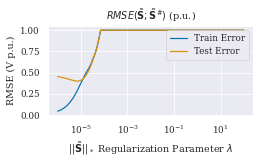

In [209]:
sns.set_context("paper")
width = 3.5
height = (width)/1.61828
fig,ax = plt.subplots(figsize=(width,height),constrained_layout=True)
ax.plot(lamb_values, train_errors, label="Train Error")
ax.set_xscale("log")
ax.set_title(r"Train Error: $RMSE(\tilde{\mathbf{S}}^*;\tilde{\mathbf{S}}_0)$ (p.u.)")
#axes[0].grid()
#axes[0].ticklabel_format(useMathText=True,useOffset=False)
ax.set_xlabel(r"$||\tilde{\mathbf{S}}||_*$ Regularization Parameter $\lambda$")
ax.plot(lamb_values, np.array(ground_truth_errors), label="Test Error")
ax.set_xscale("log")
ax.set_title(r"$RMSE(\tilde{\mathbf{S}};\tilde{\mathbf{S}}^{\#})$ (p.u.)")
ax.legend()
ax.set_ylabel("RMSE (V p.u.)")
#axes[1].grid()
#axes[1].ticklabel_format(useMathText=True,useOffset=False)
#axes[1].ticklabel_format(axis='y',style='sci',use)
#plt.suptitle("IEEE-13 Bus Jacobian Completion RMSE (p.u.)")
#plt.savefig("/home/sam/github/jacobian_discovery/Figures/rmse_cv.pdf")

In [18]:
print('Mean RMSE: ',np.mean(ground_truth_errors))

Mean RMSE:  8.285852355037928e-05


## 2.3 Compare Spectral Analysis

In [160]:
cum_sigma_gt,normed_sigma_gt = spectral_analysis(S_13)

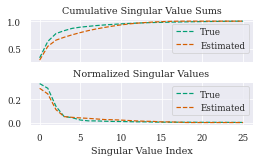

In [162]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(3.5,(3.5/1.61828)),constrained_layout=True)
axes[0].set_title("Cumulative Singular Value Sums")
axes[0].plot(cum_sigma_gt,'g--',label="True")
axes[0].plot(cum_sigma,"r--",label="Estimated")
axes[0].legend()
axes[0].set_xticklabels([])
axes[1].set_title("Normalized Singular Values")
axes[1].plot(normed_sigma_gt,"g--",label="True")
axes[1].plot(normed_sigma,"r--",label='Estimated')
axes[1].legend()
axes[1].set_xlabel("Singular Value Index")
#axes[0].set_xlabel("Singular Value Index")
plt.savefig("/home/sam/github/jacobian_discovery/Figures/spectral_recovery.pdf")

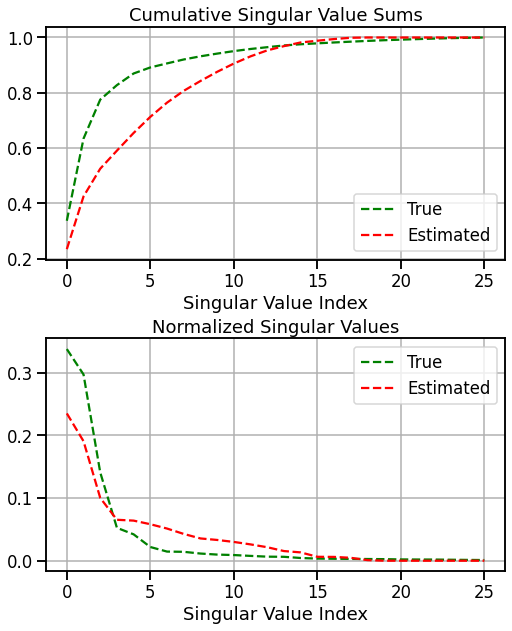

In [120]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(width,height),constrained_layout=True)
axes[0].set_title("Cumulative Singular Value Sums")
axes[0].plot(cum_sigma_gt,'g--',label="True")
axes[0].plot(cum_sigma,"r--",label="Estimated")
axes[0].legend()
axes[1].set_title("Normalized Singular Values")
axes[1].plot(normed_sigma_gt,"g--",label="True")
axes[1].plot(normed_sigma,"r--",label='Estimated')
axes[1].legend()
axes[0].grid()
axes[1].grid()
axes[1].set_xlabel("Singular Value Index")
#axes[0].set_xlabel("Singular Value Index")
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spectral_analysis.png")
########################


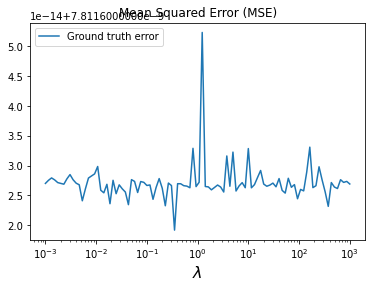

In [31]:
axes[1].plot(lamb_values, ground_truth_errors, label="Ground truth error")
axes[1].set_xscale("log")
axes[1].set_title("Perturb/Observe Error")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.title("Mean Squared Error (MSE)")
plt.show()

In [24]:
def simplex_projection(s):
    """Projection onto the unit simplex."""
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

def nuclear_projection(A):
    """Projection onto nuclear norm ball."""
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))


In [7]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(U.T))
# pick which entries we observe uniformly at random
O = np.random.randint(0,2, (n, n))
# multiply A by O coordinate-wise
Y = np.multiply(A, O)

def mc_objective(Y, O, X):
    """Matrix completion objective."""
    return 0.5 * np.linalg.norm(Y-np.multiply(X, O), 'fro')**2

def mc_gradient(Y, O, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, O) - Y

In [11]:
# start from random matrix of nuclear norm 1
X0 = np.random.normal(0,1, (n,n))
X0 = nuclear_projection(X0.dot(X0.T))
objective = lambda X: mc_objective(Y, O, X)
gradient = lambda X: mc_gradient(Y, O, X)
Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)



NameError: name 'gradient_descent' is not defined

# Item 2: Low-Rank Matrix *Recovery*

Low-Rank Matrix *Recovery* is distinct from Low-Rank matrix *approximation*. 

Instead of observing an incomplete matrix $\mathbf{X}_0$, We observe a "linear measurement" 

$$
\bar{\mathbf{d}} \approx \mathcal{A}(\mathbf{X}) + \mathbf{z} \in \mathbb{R}^L
$$

Where $\mathcal{A} : \mathbb{R}^{M \times N} \mapsto \mathbb{R}^{L}$ is a "linear measurement operator"

In [27]:
import inv_model_static as inv
#Test the static IEEE13 Estimation
buses = ['633','671']
phases = ['3','3']
kws = [ '-150','-25']
kvars = ['-100','-45']
voltages = inv.multiple_injection_voltages(inv.dss,buses,phases,kws,kvars,opendssDir=opendssDir_IEEE13)
d = np.asarray(voltages) - np.asarray(voltages_basecase)
xhat,xhat_df = est.least_squares_process(S_IEEE13[:,0:16],d,injection_labels[0:16])

ModuleNotFoundError: No module named 'inv_model_static'